In [49]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
from tqdm import tqdm

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [40]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        actions = Q[observation]
        best_action = np.argmax(Q[observation])
        actions = [epsilon/nA for i in actions]
        actions[best_action] += 1-epsilon
        return np.array(actions)
        
    return policy_fn

In [80]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        state = env.reset()
        episode = []
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        for i in range(100):
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                state_action_pairs = set([(tuple(x[0]), x[1]) for x in episode])
                for state, action in state_action_pairs:
                    first_occurence_idx = next(i for i,x in enumerate(episode) 
                                               if x[0]==state and x[1]==action)
                    G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
                    returns_sum[(state, action)] += G
                    returns_count[(state, action)] += 1.0
                    Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
                break
            state = next_state
            
    return Q, policy

In [84]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

In [82]:
Q

defaultdict(<function __main__.mc_control_epsilon_greedy.<locals>.<lambda>()>,
            {(15, 10, True): array([-0.67741935, -0.28125   ]),
             (15, 5, False): array([-0.24647887, -0.48120301]),
             (13, 8, False): array([-0.57894737, -0.28375286]),
             (17, 7, False): array([-0.10555556, -0.54545455]),
             (16, 2, True): array([-0.52, -0.36]),
             (16, 4, False): array([-0.24870466, -0.53333333]),
             (12, 2, False): array([-0.22897196, -0.47058824]),
             (14, 1, False): array([-0.64705882, -0.60141509]),
             (17, 8, False): array([-0.39007092, -0.73913043]),
             (17, 10, False): array([-0.47916667, -0.62280702]),
             (20, 9, False): array([ 0.75152749, -0.90909091]),
             (16, 2, False): array([-0.35015773, -0.41176471]),
             (20, 10, False): array([ 0.42825011, -0.81889764]),
             (20, 8, False): array([ 0.81102362, -0.55172414]),
             (17, 1, False): array([

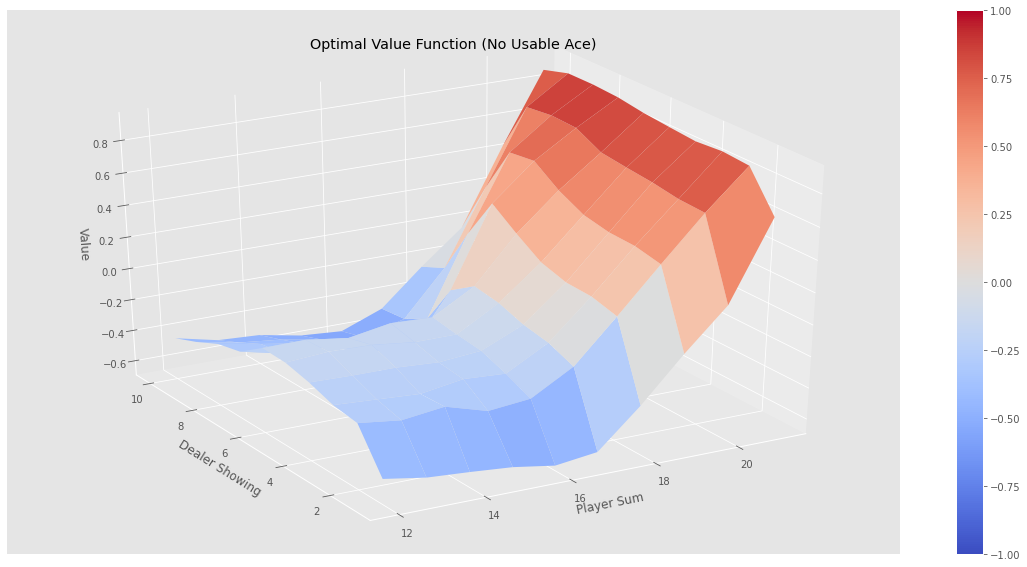

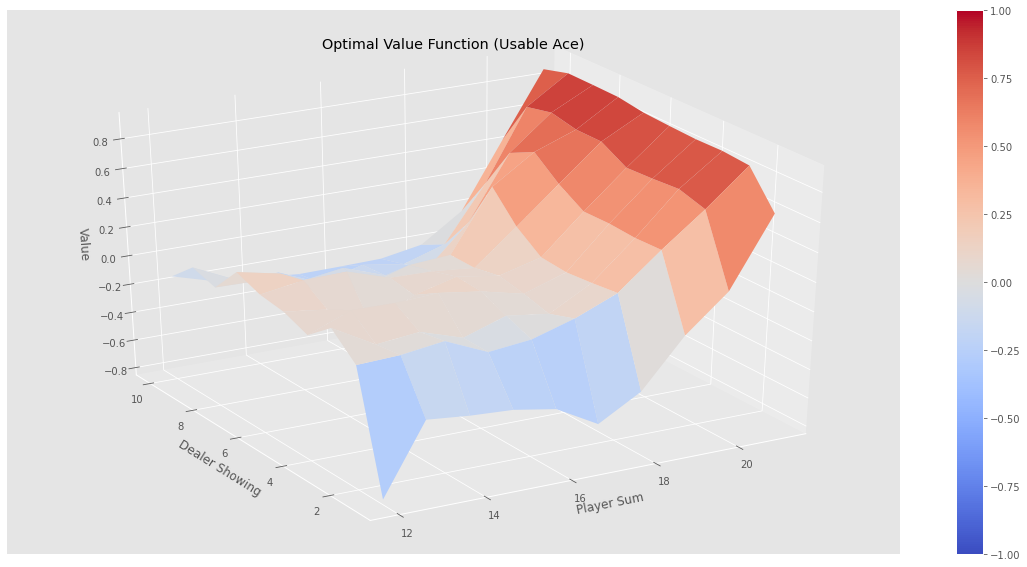

In [85]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")